### 06. Count the pairs of victimisation experiences and observations.

---
In this section, we use the two tables from the previous sections to combine the two different mechanisms.

**Things to do**
* Test the results.
* Make code modular (create a function for plotting).

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read a summary table of the victimisation-based mechanism.
PATH_TO_VIC_DATA = "s3://social-research-cheating/summary-tables/emp-net/vic/vic_30.parquet"
vic_data = spark.read.parquet(PATH_TO_VIC_DATA)
vic_data.registerTempTable("vic_data")

# Read a summary table of the observation-based mechanism.
PATH_TO_OBS_DATA = "s3://social-research-cheating/summary-tables/emp-net/obs/rev_obs_30_2.parquet"
obs_data = spark.read.parquet(PATH_TO_OBS_DATA)
obs_data.registerTempTable("obs_data")

In [3]:
# Collect the transitions that happened within seven days after observing or being killed by cheating.
vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

vic_tab.registerTempTable("vic_tab")
obs_tab.registerTempTable("obs_tab")

In [5]:
# Show the first few rows of each dataset.
vic_tab.show(5)
obs_tab.show(5)

# Convert spark dataframes into pandas dataframes.
obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.393b6ee09...|2019-03-08|2019-03-01|     7|        2|            1|           2|
|account.3f888b606...|2019-03-10|2019-03-05|     5|        7|            4|           7|
|account.4b6c650bd...|2019-03-15|2019-03-11|     4|        2|            0|           2|
|account.73e50018a...|2019-03-27|2019-03-20|     7|        1|            1|           1|
|account.b3e7bbe4a...|2019-03-09|2019-03-04|     5|        1|            0|           1|
+--------------------+----------+----------+------+---------+-------------+------------+
only showing top 5 rows

+--------------------+----------+----------+------+---------+-------------+--------------+------------+
|                  id|start_date|    m_date|period|total_obs|total_sev

### 1. Merge two tables.

In [6]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.14a9052f2...|2019-03-08|
|account.b5b8daec9...|2019-03-03|
|account.826ffb6b1...|2019-03-10|
|account.89e89a88e...|2019-03-08|
|account.d09650395...|2019-03-10|
|account.d5bdf5693...|2019-03-05|
|account.516b36389...|2019-03-05|
|account.72d7c8781...|2019-03-06|
|account.22f135474...|2019-03-07|
|account.bed69e8d7...|2019-03-03|
+--------------------+----------+
only showing top 10 rows



In [7]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                            CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.14a9052f2...|2019-03-08|       27|      3|        6|      3|
|account.b5b8daec9...|2019-03-03|        2|      0|        0|      0|
|account.826ffb6b1...|2019-03-10|        2|      0|        0|      0|
|account.89e89a88e...|2019-03-08|       10|      5|        3|      2|
|account.d09650395...|2019-03-10|        3|      1|        1|      0|
|account.d5bdf5693...|2019-03-05|        2|      0|        0|      0|
|account.516b36389...|2019-03-05|        2|      0|        0|      0|
|account.72d7c8781...|2019-03-06|       13|      2|        0|      0|
|account.22f135474...|2019-03-07|        2|      0|        0|      0|
|account.bed69e8d7...|2019-03-03|        4|      0|        0|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

### 2. Plot the distribution of experiences and observations.

In [8]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")

# Print the first 5 and last 5 rows.
print(pairs_tab.head())
print(pairs_tab.tail())

   total_obs  total_exp  freq
0          0          0   183
1          0          1   101
2          0          2    22
3          0          3     9
4          0          4     1
     total_obs  total_exp  freq
115         43          3     1
116         58          7     1
117         64          4     1
118         65          2     1
119        100          2     1


In [9]:
# Store the dataframe as an excel file.
pairs_tab.to_csv('emp_data.csv', index=False)

In [10]:
merged_tab = merged_df.toPandas()
sev_pairs_tab = merged_tab.groupby(['total_obs', 'sev_exp']).size().reset_index(name="freq")

# Print the first 5 and last 5 rows.
print(sev_pairs_tab.head())
print(sev_pairs_tab.tail())

# Store the dataframe as an excel file.
sev_pairs_tab.to_csv('sev_emp_data.csv', index=False)

   total_obs  sev_exp  freq
0          0        0   269
1          0        1    45
2          0        2     4
3          0        3     1
4          1        0   415
    total_obs  sev_exp  freq
88         43        2     1
89         58        4     1
90         64        2     1
91         65        1     1
92        100        0     1


### 3. Create a merged data table for randomised networks.

Put the number of (observations, experiences) into each cell.

In [2]:
for i in range(51, 101):
    # Read a summary table of the victimisation-based mechanism.
    vic_data = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/vic/vic_30_" 
                                 + str(i) + ".parquet")
    vic_data.registerTempTable("vic_data")

    # Read a summary table of the observation-based mechanism.
    obs_data = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/obs/rev_obs_30_5/rev_obs_30_5_" 
                                 + str(i) + ".parquet")
    obs_data.registerTempTable("obs_data")
    
    # Collect the transitions that happened within seven days after observing or being killed by cheating.
    vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
    obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

    vic_tab.registerTempTable("vic_tab")
    obs_tab.registerTempTable("obs_tab")

    obs_df = obs_tab.toPandas()
    vic_df = vic_tab.toPandas()
    
    dates_obs = obs_df[['id', 'start_date']]
    dates_vic = vic_df[['id', 'start_date']]
    dates_df = pd.concat([dates_obs, dates_vic])
    dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
    dates_df = spark.createDataFrame(dates_df)
    dates_df.registerTempTable("dates_df")
    
    add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                                CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                                CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                                FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
    add_obs_info.registerTempTable("add_obs_info")

    merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                             CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                             CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                             FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
    
    merged_tab = merged_df.toPandas()
    
    pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
    pairs_tab.to_csv('rand_data_' + str(i) + '.csv', index=False)
    
    sev_pairs_tab = merged_tab.groupby(['total_obs', 'sev_exp']).size().reset_index(name="freq")
    sev_pairs_tab.to_csv('sev_rand_data_' + str(i) + '.csv', index=False)

In [2]:
data = pd.read_csv("emp_data.csv")
data = data.rename(columns={'freq': 'E'})

rand_dat = pd.read_csv("rand_data_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','total_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
merged_df = merged_df.rename(columns={'freq': 'R1'})

for i in range(2, 51):
    rand_dat = pd.read_csv("rand_data_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'R' + str(i)})

print(merged_df.head())

   total_obs  total_exp      E     R1     R2     R3     R4     R5     R6  \
0          0          0  639.0  651.0  664.0  641.0  650.0  649.0  654.0   
1          0          1  179.0  181.0  186.0  182.0  196.0  169.0  185.0   
2          0          2   28.0   35.0   31.0   31.0   37.0   26.0   35.0   
3          0          3   11.0    7.0    9.0   12.0    9.0   15.0    8.0   
4          0          4    1.0    1.0    2.0    4.0    2.0    3.0    4.0   

      R7  ...      R41    R42    R43    R44    R45    R46    R47    R48  \
0  670.0  ...    659.0  654.0  668.0  654.0  634.0  677.0  667.0  648.0   
1  179.0  ...    179.0  179.0  184.0  177.0  188.0  172.0  171.0  180.0   
2   27.0  ...     30.0   36.0   34.0   26.0   24.0   37.0   29.0   34.0   
3    6.0  ...     15.0    6.0    7.0    9.0   10.0   11.0   11.0    8.0   
4    3.0  ...      3.0    5.0    1.0    3.0    0.0    1.0    3.0    1.0   

     R49    R50  
0  659.0  646.0  
1  193.0  171.0  
2   30.0   26.0  
3    9.0    9.0  
4 

In [3]:
merged_df = pd.read_csv("SO_RE.csv")

for i in range(51, 101):
    rand_dat = pd.read_csv("rand_data_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'R' + str(i)})

print(merged_df.head())

   total_obs  total_exp      E     R1     R2     R3     R4     R5     R6  \
0          0          0  639.0  651.0  664.0  641.0  650.0  649.0  654.0   
1          0          1  179.0  181.0  186.0  182.0  196.0  169.0  185.0   
2          0          2   28.0   35.0   31.0   31.0   37.0   26.0   35.0   
3          0          3   11.0    7.0    9.0   12.0    9.0   15.0    8.0   
4          0          4    1.0    1.0    2.0    4.0    2.0    3.0    4.0   

      R7  ...      R91    R92    R93    R94    R95    R96    R97    R98  \
0  670.0  ...    655.0  649.0  670.0  647.0  663.0  629.0  666.0  658.0   
1  179.0  ...    166.0  184.0  181.0  184.0  180.0  181.0  172.0  172.0   
2   27.0  ...     32.0   29.0   27.0   21.0   23.0   19.0   26.0   20.0   
3    6.0  ...      9.0    8.0    7.0    5.0   10.0   11.0    7.0   11.0   
4    3.0  ...      1.0    3.0    3.0    3.0    0.0    2.0    4.0    1.0   

     R99   R100  
0  660.0  660.0  
1  193.0  186.0  
2   25.0   28.0  
3   10.0    5.0  
4 

In [4]:
merged_df.to_csv('SO_RE_rev.csv', index=False)

In [4]:
data = pd.read_csv("sev_emp_data.csv")
data = data.rename(columns={'freq': 'E'})

rand_dat = pd.read_csv("sev_rand_data_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','sev_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','sev_exp'])
merged_df = merged_df.rename(columns={'freq': 'R1'})

for i in range(2, 51):
    rand_dat = pd.read_csv("sev_rand_data_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','sev_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','sev_exp'])
    merged_df = merged_df.rename(columns={'freq': 'R' + str(i)})

print(merged_df.head())

   total_obs  sev_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0          0        0  798.0  798.0  826.0  794.0  820.0  802.0  811.0  808.0   
1          0        1   58.0   73.0   58.0   66.0   69.0   48.0   71.0   71.0   
2          0        2    4.0    5.0    6.0    9.0    5.0   11.0    3.0    6.0   
3          0        3    1.0    1.0    2.0    1.0    0.0    1.0    1.0    0.0   
4          0        4    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   

   ...      R41    R42    R43    R44    R45    R46    R47    R48    R49    R50  
0  ...    798.0  802.0  813.0  802.0  797.0  826.0  810.0  803.0  814.0  792.0  
1  ...     82.0   72.0   75.0   62.0   53.0   70.0   65.0   65.0   75.0   53.0  
2  ...      4.0    7.0    7.0    8.0    7.0    4.0    6.0    3.0    3.0   11.0  
3  ...      3.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0    2.0    0.0  
4  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 53 columns]


In [5]:
merged_df = pd.read_csv("SO_SE.csv")

for i in range(51, 101):
    rand_dat = pd.read_csv("sev_rand_data_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','sev_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','sev_exp'])
    merged_df = merged_df.rename(columns={'freq': 'R' + str(i)})

print(merged_df.head())

   total_obs  sev_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0          0        0  798.0  798.0  826.0  794.0  820.0  802.0  811.0  808.0   
1          0        1   58.0   73.0   58.0   66.0   69.0   48.0   71.0   71.0   
2          0        2    4.0    5.0    6.0    9.0    5.0   11.0    3.0    6.0   
3          0        3    1.0    1.0    2.0    1.0    0.0    1.0    1.0    0.0   
4          0        4    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   

   ...      R91    R92    R93    R94    R95    R96    R97    R98    R99   R100  
0  ...    798.0  805.0  819.0  794.0  815.0  778.0  815.0  794.0  819.0  826.0  
1  ...     63.0   63.0   63.0   64.0   57.0   59.0   55.0   63.0   60.0   53.0  
2  ...      3.0    6.0    6.0    4.0    5.0    7.0    8.0    5.0   11.0    5.0  
3  ...      0.0    0.0    0.0    1.0    1.0    1.0    0.0    2.0    0.0    2.0  
4  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 103 columns]


In [6]:
merged_df.to_csv('SO_SE_rev.csv', index=False)

### 4. Create a heatmap.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import matplotlib
# from matplotlib.colors import DivergingNorm
import scipy.stats

In [2]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'PiYG',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 14, # Adjust the font size of x and y labels.
    'axes.titlesize': 16,
    'axes.facecolor': 'gray',
    'font.size': 12, 
    'legend.fontsize': 6,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': True,
    'figure.figsize': [15, 7],
    'font.family': 'serif'
}
matplotlib.rcParams.update(params)


def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

### Calculate the P-values of each motif - (1, 0), (0, 1), and (1, 1).

### 1) Calculate the test statistics - strict def. of experience and observation.

In [13]:
### Calculate the total number of the motif (0, 1) for each network.
merged_df = pd.read_csv('data/SO_SE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

test_dat = test_dat[test_dat.sev_exp == 0]
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_obs'], axis="index")

temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(round(p_val, 2)))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(round(prob, 2)))
print("cum_prop: " + str(round(cum_prop, 2)))

# temp_dat.to_csv('sum_tab.csv', index=False)

            E      R1      R2      R3      R4      R5      R6      R7      R8  \
total  1643.0  1633.0  1681.0  1615.0  1628.0  1637.0  1618.0  1668.0  1613.0   

           R9  ...     R91     R92     R93     R94     R95     R96     R97  \
total  1587.0  ...  1610.0  1620.0  1573.0  1611.0  1595.0  1660.0  1681.0   

          R98     R99    R100  
total  1631.0  1632.0  1573.0  

[1 rows x 101 columns]
1643.0
[1633. 1681. 1615. 1628. 1637. 1618. 1668. 1613. 1587. 1680. 1655. 1579.
 1609. 1626. 1647. 1591. 1673. 1725. 1651. 1585. 1625. 1617. 1634. 1622.
 1604. 1571. 1549. 1571. 1619. 1575. 1608. 1577. 1596. 1595. 1599. 1657.
 1604. 1576. 1634. 1639. 1637. 1638. 1641. 1643. 1568. 1594. 1594. 1619.
 1604. 1660. 1589. 1633. 1606. 1560. 1591. 1647. 1587. 1659. 1577. 1607.
 1603. 1585. 1672. 1599. 1578. 1631. 1682. 1577. 1653. 1630. 1634. 1653.
 1659. 1533. 1562. 1599. 1604. 1581. 1691. 1686. 1567. 1581. 1577. 1586.
 1622. 1645. 1638. 1599. 1612. 1619. 1610. 1620. 1573. 1611. 1595. 1660.
 

In [14]:
merged_df = pd.read_csv('data/SO_SE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

# Calculate the test statistics of the motif (1, 0).
test_dat = test_dat[test_dat.total_obs == 0]
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['sev_exp'], axis="index")
# print(temp_dat)

temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(round(p_val, 2)))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(round(prob, 2)))
print("cum_prop: " + str(round(cum_prop, 2)))

# temp_dat.to_csv('sum_tab.csv', index=False)

          E    R1    R2    R3    R4    R5    R6    R7    R8    R9  ...   R91  \
total  69.0  86.0  76.0  87.0  83.0  73.0  80.0  83.0  79.0  87.0  ...  69.0   

        R92   R93   R94   R95   R96   R97   R98   R99  R100  
total  75.0  75.0  75.0  70.0  76.0  71.0  79.0  82.0  69.0  

[1 rows x 101 columns]
69.0
[86. 76. 87. 83. 73. 80. 83. 79. 87. 86. 72. 82. 76. 83. 89. 78. 76. 60.
 77. 77. 72. 91. 81. 85. 79. 82. 86. 73. 82. 74. 81. 82. 84. 72. 75. 81.
 88. 79. 79. 77. 99. 86. 89. 78. 67. 78. 80. 74. 87. 75. 76. 84. 67. 79.
 74. 75. 81. 87. 79. 78. 96. 75. 76. 75. 69. 69. 88. 68. 75. 81. 89. 73.
 80. 85. 81. 67. 80. 81. 92. 82. 78. 73. 64. 78. 80. 75. 76. 83. 77. 78.
 69. 75. 75. 75. 70. 76. 71. 79. 82. 69.]
rand_mean: 78.71
rand_std: 6.72
z-score: -1.44
p_val (z-score): 0.93
cdf: 0.15
pmf: 0.03
prob: 0.88
cum_prop: 0.94


In [15]:
# Count the number of the motif (1, 1).
merged_df = pd.read_csv('data/SO_SE.csv')

# Drop the rows with zero experience and zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) | (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
test_dat['num_pairs'] = np.where(test_dat['total_obs'] <= test_dat['sev_exp'], 
                                 test_dat['total_obs'], test_dat['sev_exp'])

temp_dat = test_dat.loc[:,'E':'R100'].multiply(test_dat['num_pairs'], axis="index")

# Calculate the total number of the motif (1, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))

           E     R1     R2     R3     R4     R5     R6     R7     R8     R9  \
total  332.0  289.0  280.0  300.0  300.0  282.0  287.0  294.0  297.0  280.0   

       ...    R91    R92    R93    R94    R95    R96    R97    R98    R99  \
total  ...  285.0  309.0  306.0  279.0  273.0  276.0  272.0  277.0  281.0   

        R100  
total  284.0  

[1 rows x 101 columns]
332.0
[289. 280. 300. 300. 282. 287. 294. 297. 280. 275. 296. 288. 276. 294.
 274. 298. 271. 278. 279. 296. 297. 287. 281. 266. 297. 280. 285. 283.
 291. 288. 297. 291. 304. 291. 285. 273. 282. 292. 287. 282. 283. 266.
 273. 294. 320. 277. 303. 285. 286. 281. 300. 294. 281. 297. 282. 281.
 283. 280. 308. 285. 268. 292. 278. 304. 300. 275. 294. 309. 286. 275.
 295. 297. 272. 311. 297. 297. 295. 289. 282. 271. 287. 293. 299. 287.
 295. 281. 285. 288. 301. 279. 285. 309. 306. 279. 273. 276. 272. 277.
 281. 284.]
rand_mean: 287.56
rand_std: 10.88
z-score: 4.08
p_val (z-score): 2.2239413893232474e-05
cdf: 1.0
pmf: 0.0
prob: 0.005

### 2) Calculate the test statistics - simple def. of experience and observation.

In [16]:
merged_df = pd.read_csv('data/RO_RE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

# Calculate the test statistics of the motif (0, 1).
test_dat = test_dat[test_dat.total_exp == 0]
# print(test_dat.head())
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_obs'], axis="index")
# print(temp_dat)

# Calculate the total number of the motif (0, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))
# temp_dat.to_csv('sum_tab.csv', index=False)

            E      R1      R2      R3      R4      R5      R6      R7      R8  \
total  3377.0  3187.0  3370.0  3232.0  3245.0  3274.0  3051.0  3248.0  3249.0   

           R9  ...     R91     R92     R93     R94     R95     R96     R97  \
total  3364.0  ...  3338.0  3212.0  3327.0  3296.0  3369.0  3242.0  3413.0   

          R98     R99    R100  
total  3288.0  3269.0  3264.0  

[1 rows x 101 columns]
3377.0
[3187. 3370. 3232. 3245. 3274. 3051. 3248. 3249. 3364. 3170. 3255. 3320.
 3231. 3158. 3352. 3369. 3316. 3340. 3249. 3268. 3240. 3348. 3196. 3308.
 3176. 3385. 3236. 3312. 3192. 3137. 3255. 3279. 3290. 3204. 3208. 3199.
 3362. 3149. 3391. 3288. 3145. 3387. 3281. 3121. 3278. 3332. 3290. 3130.
 3324. 3241. 3250. 3448. 3454. 3278. 3303. 3251. 3230. 3278. 3211. 3297.
 3200. 3310. 3341. 3191. 3331. 3331. 3236. 3224. 3341. 3247. 3281. 3377.
 3281. 3322. 3182. 3338. 3211. 3158. 3389. 3386. 3211. 3281. 3136. 3371.
 3275. 3357. 3274. 3410. 3206. 3221. 3338. 3212. 3327. 3296. 3369. 3242.
 

In [17]:
merged_df = pd.read_csv('data/RO_RE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

# Calculate the test statistics of the motif (1, 0).
test_dat = test_dat[test_dat.total_obs == 0]
print(test_dat.head())
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_exp'], axis="index")

# Calculate the total number of the motif (1, 0) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))

     total_obs  total_exp      E     R1     R2     R3     R4    R5     R6  \
40           0          1  101.0  100.0  102.0  101.0  119.0  92.0  108.0   
107          0          2   22.0   27.0   25.0   24.0   27.0  20.0   28.0   
181          0          3    9.0    5.0    8.0   11.0    5.0  12.0    8.0   
248          0          4    1.0    1.0    2.0    3.0    2.0   3.0    4.0   
318          0          5    3.0    2.0    0.0    0.0    1.0   0.0    0.0   

        R7  ...   R91   R92    R93    R94    R95    R96   R97    R98    R99  \
40   103.0  ...  93.0  94.0  100.0  104.0  101.0  104.0  96.0  100.0  106.0   
107   20.0  ...  26.0  22.0   19.0   18.0   18.0   14.0  19.0   19.0   19.0   
181    5.0  ...   7.0   6.0    7.0    3.0    8.0    8.0   7.0    9.0    8.0   
248    3.0  ...   1.0   3.0    3.0    3.0    0.0    2.0   4.0    1.0    2.0   
318    0.0  ...   1.0   1.0    0.0    3.0    2.0    0.0   3.0    1.0    0.0   

      R100  
40   113.0  
107   21.0  
181    3.0  
248    5.0

In [18]:
# Count the number of the motif (1, 1).
merged_df = pd.read_csv('data/RO_RE.csv')

# Drop the rows with zero experience and zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) | (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
test_dat['num_pairs'] = np.where(test_dat['total_obs'] <= test_dat['total_exp'], 
                                 test_dat['total_obs'], test_dat['total_exp'])

temp_dat = test_dat.loc[:,'E':'R100'].multiply(test_dat['num_pairs'], axis="index")

# Calculate the total number of the motif (1, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))

           E     R1     R2     R3     R4     R5     R6     R7     R8     R9  \
total  740.0  719.0  697.0  723.0  721.0  700.0  715.0  713.0  698.0  694.0   

       ...    R91    R92    R93    R94    R95    R96    R97    R98    R99  \
total  ...  692.0  739.0  722.0  694.0  666.0  684.0  686.0  670.0  708.0   

        R100  
total  679.0  

[1 rows x 101 columns]
740.0
[719. 697. 723. 721. 700. 715. 713. 698. 694. 718. 708. 696. 694. 721.
 674. 705. 686. 686. 691. 717. 709. 689. 707. 673. 717. 688. 714. 681.
 728. 706. 721. 720. 705. 708. 710. 704. 692. 730. 703. 711. 695. 681.
 705. 724. 731. 676. 735. 722. 693. 682. 720. 700. 665. 714. 696. 728.
 718. 669. 726. 712. 685. 698. 684. 715. 715. 680. 727. 729. 701. 707.
 729. 699. 717. 713. 702. 678. 734. 695. 697. 683. 690. 709. 726. 695.
 698. 691. 715. 705. 717. 697. 692. 739. 722. 694. 666. 684. 686. 670.
 708. 679.]
rand_mean: 703.55
rand_std: 17.4
z-score: 2.09
p_val (z-score): 0.018095507186522863
cdf: 0.92
pmf: 0.01
prob: 0.0884

In [12]:
### Calculate the test statistics of the motif (0, 1).
merged_df = pd.read_csv('data/RO_SE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
test_dat = test_dat[test_dat.sev_exp == 0]

temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_obs'], axis="index")

# Calculate the total number of the motif (0, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))


### Calculate the test statistics of the motif (1, 0).
merged_df = pd.read_csv('data/RO_SE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
test_dat = test_dat[test_dat.total_obs == 0]
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['sev_exp'], axis="index")

# Calculate the total number of the motif (0, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))


### Count the number of the motif (1, 1).
merged_df = pd.read_csv('data/RO_SE.csv')

# Drop the rows with zero experience and zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) | (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
test_dat['num_pairs'] = np.where(test_dat['total_obs'] <= test_dat['sev_exp'], 
                                 test_dat['total_obs'], test_dat['sev_exp'])

temp_dat = test_dat.loc[:,'E':'R100'].multiply(test_dat['num_pairs'], axis="index")

# Calculate the total number of the motif (1, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))

            E      R1      R2      R3      R4      R5      R6      R7      R8  \
total  4833.0  4931.0  5064.0  4810.0  4882.0  4926.0  4830.0  4899.0  4804.0   

           R9  ...     R91     R92     R93     R94     R95     R96     R97  \
total  4828.0  ...  4892.0  4876.0  4803.0  4811.0  4861.0  4925.0  5055.0   

          R98     R99    R100  
total  4986.0  4860.0  4823.0  

[1 rows x 101 columns]
4833.0
[4931. 5064. 4810. 4882. 4926. 4830. 4899. 4804. 4828. 5002. 4860. 4799.
 4848. 4837. 4983. 4742. 5020. 5074. 4997. 4790. 4854. 4907. 4975. 4933.
 4827. 4824. 4770. 4738. 4894. 4846. 4821. 4890. 4790. 4782. 4805. 5076.
 4849. 4744. 4973. 4918. 4842. 4961. 4944. 4788. 4717. 4868. 4743. 4920.
 4822. 4914. 4810. 4864. 4793. 4777. 4785. 4977. 4833. 5020. 4755. 4808.
 4782. 4814. 4957. 4847. 4783. 4926. 4925. 4755. 4955. 4884. 4853. 4981.
 4960. 4683. 4761. 4828. 4823. 4800. 5036. 4980. 4734. 4820. 4792. 4815.
 4872. 4934. 4894. 4840. 4845. 4845. 4892. 4876. 4803. 4811. 4861. 4925.
 

In [11]:
from scipy.stats import norm

### Calculate the test statistics of the motif (0, 1).
merged_df = pd.read_csv('data/SO_RE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

test_dat = test_dat[test_dat.total_exp == 0]
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_obs'], axis="index")

# Calculate the total number of the motif (0, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))


### Calculate the test statistics of the motif (1, 0).
merged_df = pd.read_csv('data/SO_RE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

test_dat = test_dat[test_dat.total_obs == 0]
# print(test_dat.head())
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_exp'], axis="index")
# print(temp_dat)

# Calculate the total number of the motif (1, 0) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))


### Count the number of the motif (1, 1).
merged_df = pd.read_csv('data/SO_RE.csv')

# Drop the rows with zero experience and zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) | (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
test_dat['num_pairs'] = np.where(test_dat['total_obs'] <= test_dat['total_exp'], 
                                 test_dat['total_obs'], test_dat['total_exp'])
temp_dat = test_dat.loc[:,'E':'R100'].multiply(test_dat['num_pairs'], axis="index")

# Calculate the total number of the motif (1, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
print(temp_dat.tail(1))
print(temp_dat.iloc[-1, 0])
print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 2)))
print("rand_std: " + str(round(rand_std, 2)))
print("z-score: " + str(round(z_score, 2)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 2)))
print("pmf: " + str(round(pmf, 2)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))

            E      R1      R2      R3      R4      R5      R6      R7      R8  \
total  1140.0  1063.0  1109.0  1095.0  1076.0  1102.0  1020.0  1077.0  1057.0   

           R9  ...     R91     R92     R93     R94     R95     R96     R97  \
total  1092.0  ...  1088.0  1062.0  1097.0  1098.0  1107.0  1090.0  1116.0   

          R98     R99    R100  
total  1066.0  1113.0  1071.0  

[1 rows x 101 columns]
1140.0
[1063. 1109. 1095. 1076. 1102. 1020. 1077. 1057. 1092. 1072. 1067. 1091.
 1061. 1060. 1100. 1122. 1093. 1119. 1059. 1088. 1099. 1107. 1039. 1086.
 1044. 1107. 1057. 1108. 1057. 1020. 1075. 1048. 1074. 1062. 1056. 1037.
 1115. 1023. 1123. 1110. 1050. 1113. 1077. 1081. 1100. 1088. 1089. 1010.
 1094. 1097. 1057. 1163. 1133. 1068. 1099. 1096. 1053. 1062. 1058. 1097.
 1054. 1056. 1120. 1059. 1125. 1103. 1100. 1072. 1099. 1076. 1111. 1131.
 1076. 1088. 1042. 1098. 1065. 1040. 1130. 1154. 1077. 1055. 1030. 1126.
 1089. 1112. 1081. 1134. 1036. 1073. 1088. 1062. 1097. 1098. 1107. 1090.
 

### Plot a heatmap of strict observations and relaxed experiences.

total_obs      0      1      2      3      4      5      6      7      8  \
total_exp                                                                  
0          0.738  0.505  0.435  0.457  0.248  0.085  0.134  0.910  0.128   
1          0.519  0.505  0.796  0.274  0.788  0.285  0.707  0.316  0.594   
2          0.620  0.336  0.350  0.097  0.296  0.856  0.582  0.676  0.678   
3          0.314  0.297  0.239  0.935  0.628  0.720  0.500  0.028  0.057   

total_obs      9  
total_exp         
0          0.712  
1          0.893  
2          0.461  
3          0.497  


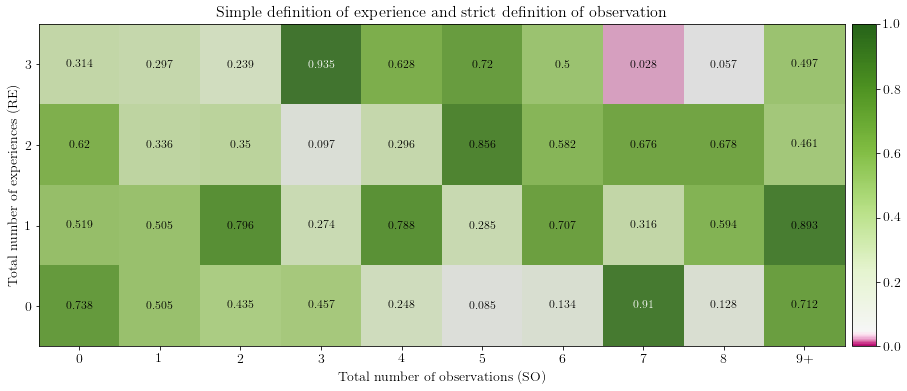

In [29]:
merged_df = pd.read_csv('data/SO_RE.csv')
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

col_list = list(test_dat.columns[2:])

res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs, 
                                                   [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, np.inf], 
                                                   labels = [0, 1, 2, 3, 4, 
                                                             5, 6, 7, 8, 9])])[col_list].sum().reset_index()

test_dat = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf, 0, 1, 2, np.inf], 
                                              labels = [0, 1, 2, 3])])[col_list].sum().reset_index()

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
# print(test_dat.head())

piv = pd.pivot_table(test_dat, values="prob",index=["total_exp"], columns=["total_obs"])
print(piv)

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)
fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
new_xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, '9+']
ax.set_xticklabels(new_xticks)
new_yticks = [0, 1, 2, '3+']
ax.set_yticklabels(new_yticks)
plt.title('Simple definition of experience and strict definition of observation')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (RE)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SO_RE_p_vals.png')

Plot a heatmap of strict observations and strict experiences.

total_obs      0      1      2      3      4      5      6      7      8  \
sev_exp                                                                    
0          0.605  0.643  0.778  0.361  0.331  0.213  0.322  0.924  0.123   
1          0.811  0.095  0.349  0.144  0.805  0.448  0.347  0.204  0.457   
2          0.789  0.723  0.016  0.876  0.182  0.615  0.736  0.016  0.209   

total_obs      9  
sev_exp           
0          0.538  
1          0.936  
2          0.507  


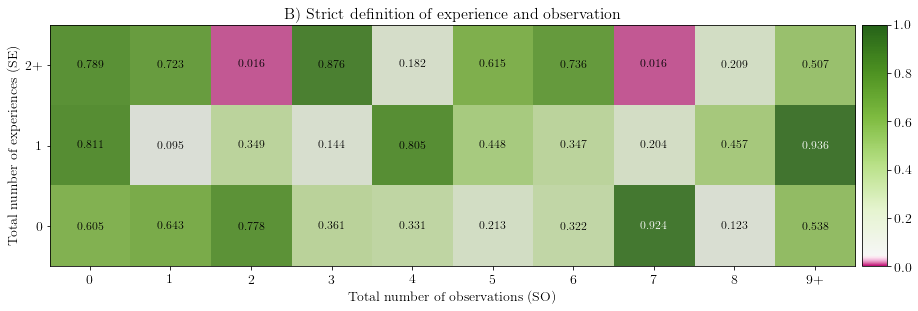

In [4]:
merged_df = pd.read_csv('data/SO_SE.csv')
test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

col_list = list(test_dat.columns[2:])
res = test_dat.groupby([test_dat.sev_exp, pd.cut(test_dat.total_obs, 
                                                   [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, np.inf], 
                                                   labels = [0, 1, 2, 3, 4, 
                                                             5, 6, 7, 8, 9])])[col_list].sum().reset_index()

test_dat = res.groupby([res.total_obs, pd.cut(res.sev_exp,[-np.inf, 0, 1, np.inf], 
                                              labels = [0, 1, 2])])[col_list].sum().reset_index()

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
# print(test_dat.head())

piv = pd.pivot_table(test_dat, values="prob",index=["sev_exp"], columns=["total_obs"])
print(piv)

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
new_xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, '9+']
ax.set_xticklabels(new_xticks)
ax.set_yticks(np.arange(piv.shape[0]))
new_yticks = [0, 1, '2+']
ax.set_yticklabels(new_yticks)
plt.title('B) Strict definition of experience and observation')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (SE)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0])


cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SO_SE_p_vals.png')

### Plot a heatmap of relaxed observations and relaxed experiences.

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.332  0.804  0.493  0.635  0.300  0.743  0.680  0.124  0.616   
1          0.531  0.257  0.404  0.222  0.907  0.515  0.693  0.695  0.318   
2          0.570  0.706  0.784  0.063  0.887  0.006  0.692  0.373  0.846   
3          0.347  1.000  0.564  0.253  0.112  1.000  1.000  0.036  0.689   

total_obs     9      10     11     12  
total_exp                              
0          0.053  0.945  0.218  0.308  
1          0.986  0.310  0.777  0.682  
2          0.129  0.566  0.056  0.831  
3          0.454  0.409  1.000  0.196  


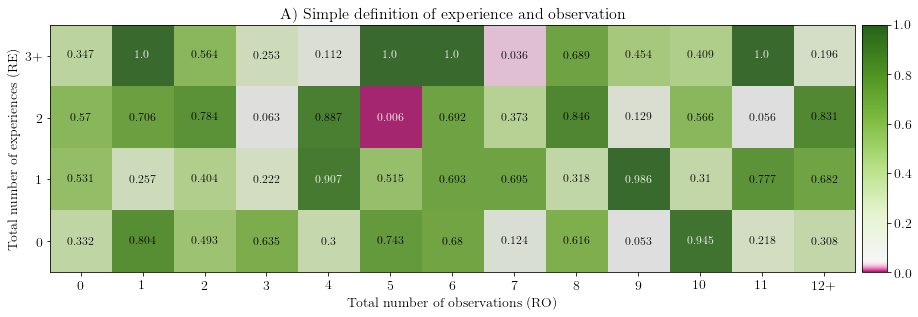

In [3]:
merged_df = pd.read_csv('data/RO_RE.csv')
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

col_list = list(test_dat.columns[2:])
res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs, 
                                                   [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf], 
                                                   labels = [0, 1, 2, 3, 4, 5, 6, 
                                                             7, 8, 9, 10, 11, 12])])[col_list].sum().reset_index()

test_dat = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf, 0, 1, 2, np.inf], 
                                              labels = [0, 1, 2, 3])])[col_list].sum().reset_index()

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})

piv = pd.pivot_table(test_dat, values="prob",index=["total_exp"], columns=["total_obs"])
print(piv)

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
new_xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12+']
ax.set_xticklabels(new_xticks)
ax.set_yticks(np.arange(piv.shape[0]))
new_yticks = [0, 1, 2, '3+']
ax.set_yticklabels(new_yticks)
plt.title('A) Simple definition of experience and observation')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (RE)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0])


cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/RO_RE_p_vals.png')

Plot a heatmap of strict experiences and observations.

total_obs     0     1      2      3      4      5      6      7      8   \
sev_exp                                                                   
0          0.299  0.79  0.492  0.311  0.492  0.682  0.885  0.397  0.797   
1          0.567  0.21  0.498  0.472  0.858  0.202  0.366  0.312  0.171   
2          0.740  1.00  0.423  0.352  0.251  0.214  0.861  0.007  0.824   

total_obs     9      10     11     12  
sev_exp                                
0          0.246  0.987  0.090  0.433  
1          0.665  0.067  0.875  0.688  
2          0.559  0.228  0.633  0.350  


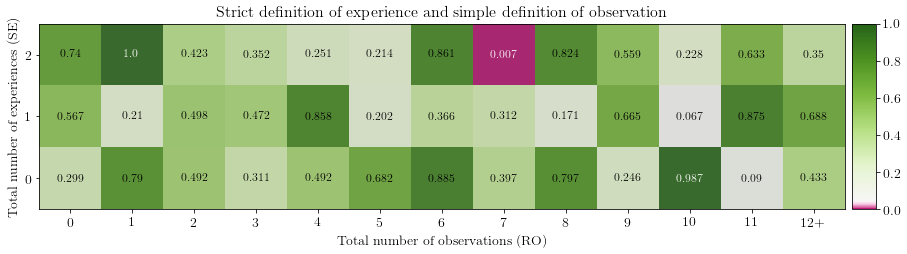

In [32]:
merged_df = pd.read_csv('data/RO_SE.csv')
test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

col_list = list(test_dat.columns[2:])
res = test_dat.groupby([test_dat.sev_exp, pd.cut(test_dat.total_obs, 
                                                 [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf], 
                                                 labels = [0, 1, 2, 3, 4, 5, 6, 
                                                           7, 8, 9, 10, 11, 12])])[col_list].sum().reset_index()

test_dat = res.groupby([res.total_obs, pd.cut(res.sev_exp,[-np.inf, 0, 1, np.inf], 
                                              labels = [0, 1, 2])])[col_list].sum().reset_index()

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
# print(test_dat.head())

piv = pd.pivot_table(test_dat, values="prob",index=["sev_exp"], columns=["total_obs"])
print(piv)

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_xticklabels(new_xticks)
ax.set_yticklabels(new_yticks)
plt.title('Strict definition of experience and simple definition of observation')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SE)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0])


cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/RO_SE_p_vals.png')

Plot the number of counts in cells.

In [11]:
freq_piv = pd.pivot_table(test_dat, values="E",index=["total_exp"], columns=["total_obs"])
print(freq_piv)

total_obs     0      1      2     3     4     5    6    7    8    9   ...  \
total_exp                                                             ...   
0          644.0  330.0  122.0  50.0  26.0  18.0  8.0  2.0  5.0  2.0  ...   
1          180.0  109.0   57.0  41.0  16.0  17.0  5.0  6.0  2.0  1.0  ...   
2           29.0   23.0   19.0  20.0  11.0   5.0  3.0  2.0  3.0  1.0  ...   
3           11.0    4.0    4.0   2.0   2.0   6.0  3.0  3.0  2.0  1.0  ...   
4            1.0    0.0    1.0   1.0   3.0   0.0  1.0  2.0  1.0  0.0  ...   
5            3.0    0.0    0.0   0.0   2.0   0.0  1.0  2.0  1.0  0.0  ...   
6            0.0    NaN    NaN   0.0   0.0   0.0  0.0  0.0  1.0  0.0  ...   
7            0.0    NaN    0.0   NaN   0.0   0.0  0.0  0.0  0.0  0.0  ...   
8            NaN    NaN    NaN   NaN   0.0   0.0  NaN  NaN  0.0  NaN  ...   
9            NaN    NaN    NaN   NaN   NaN   NaN  NaN  NaN  0.0  NaN  ...   
10           NaN    NaN    NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  ...   

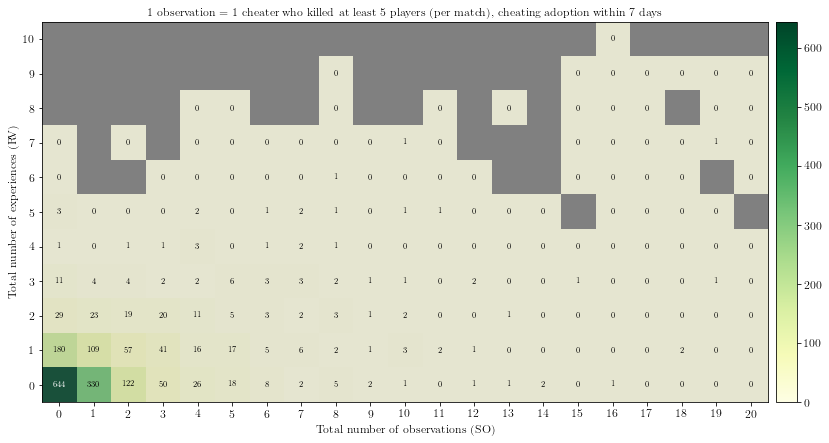

In [13]:
fig, ax = plt.subplots()
img1 = ax.imshow(freq_piv, cmap='YlGn', alpha=0.8)
ax.set_xticks(np.arange(freq_piv.shape[1]))
ax.set_yticks(np.arange(freq_piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (RV)')

textcolors = ["k", "w"]

for y in range(freq_piv.shape[0]):
    for x in range(freq_piv.shape[1]):
        if np.isnan(freq_piv[x][y]) == False:
            text = ax.text(x, y, int(freq_piv[x][y]), ha="center", va="center",
                           color=textcolors[1 if freq_piv[x][y] >= 400 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SO_RV_freq.png')

Plot a heatmap of strict experiences and relaxed/strict observations.

In [22]:
merged_df = pd.read_csv('data/SV_RO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)

test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
print(test_dat.head())

   total_obs  sev_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0          0        0  269.0  259.0  269.0  246.0  281.0  254.0  260.0  258.0   
1          1        0  412.0  440.0  427.0  449.0  427.0  433.0  444.0  436.0   
2          2        0  254.0  247.0  244.0  239.0  243.0  255.0  236.0  240.0   
3          3        0  165.0  156.0  167.0  164.0  169.0  155.0  160.0  143.0   
4          4        0  114.0  105.0  115.0  113.0  104.0  122.0  104.0  115.0   

   ...    R45    R46    R47    R48    R49    R50  rand_mean    cdf    pmf  \
0  ...  259.0  256.0  258.0  276.0  268.0  262.0     260.94  0.704  0.021   
1  ...  415.0  420.0  429.0  420.0  426.0  432.0     429.74  0.203  0.014   
2  ...  261.0  258.0  253.0  254.0  251.0  236.0     248.18  0.659  0.023   
3  ...  164.0  177.0  156.0  158.0  168.0  175.0     161.94  0.615  0.030   
4  ...  110.0  104.0  106.0  108.0  105.0  107.0     110.08  0.668  0.035   

    prob  
0  0.317  
1  0.810  
2  0.364  
3  0.4

In [58]:
piv = pd.pivot_table(test_dat, values="prob",index=["sev_exp"], columns=["total_obs"])
print(piv)

total_obs     0      1      2      3      4      5      6      7      8   \
sev_exp                                                                    
0          0.317  0.810  0.364  0.415  0.367  0.803  0.876  0.497  0.743   
1          0.598  0.226  0.461  0.489  0.829  0.214  0.347  0.286  0.191   
2          0.812  1.000  0.381  0.129  0.494  0.275  0.802  0.036  0.853   
3          0.493    NaN    NaN  1.000  1.000  0.077  1.000  0.197  0.012   
4          1.000    NaN    NaN    NaN    NaN    NaN    NaN  1.000  1.000   
5            NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

total_obs     9   ...     11     12     13     14     15     16     17     18  \
sev_exp           ...                                                           
0          0.331  ...  0.077  0.620  0.583  0.910  0.397  0.562  0.815  0.492   
1          0.763  ...  0.850  0.779  0.559  0.457  0.402  0.031  0.603  0.636   
2          1.000  ...  0.442  0.674  0.743  1.000  0.469  1.000  1.

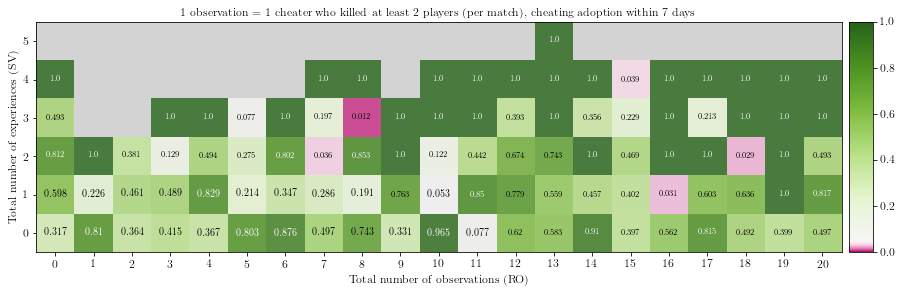

In [59]:
freq_piv = pd.pivot_table(test_dat, values="E",index=["sev_exp"], columns=["total_obs"])

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SV)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.8 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SV_RO_p_vals.png')

In [23]:
freq_piv = pd.pivot_table(test_dat, values="E",index=["sev_exp"], columns=["total_obs"])
print(freq_piv)

total_obs     0      1      2      3      4     5     6     7     8     9   \
sev_exp                                                                      
0          269.0  412.0  254.0  165.0  114.0  66.0  48.0  44.0  27.0  28.0   
1           45.0   28.0   24.0   23.0   17.0  21.0  17.0  18.0  19.0   9.0   
2            4.0    0.0    1.0    3.0    2.0   3.0   1.0   5.0   2.0   0.0   
3            1.0    NaN    NaN    0.0    0.0   1.0   0.0   1.0   3.0   0.0   
4            0.0    NaN    NaN    NaN    NaN   NaN   NaN   0.0   0.0   NaN   
5            NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   

total_obs  ...    11   12   13   14   15   16   17   18   19   20  
sev_exp    ...                                                     
0          ...  15.0  9.0  6.0  4.0  7.0  7.0  2.0  3.0  3.0  3.0  
1          ...   3.0  3.0  3.0  6.0  4.0  8.0  3.0  2.0  0.0  1.0  
2          ...   2.0  1.0  1.0  0.0  2.0  0.0  0.0  3.0  0.0  1.0  
3          ...   0.0  1.0  0.0  1.0

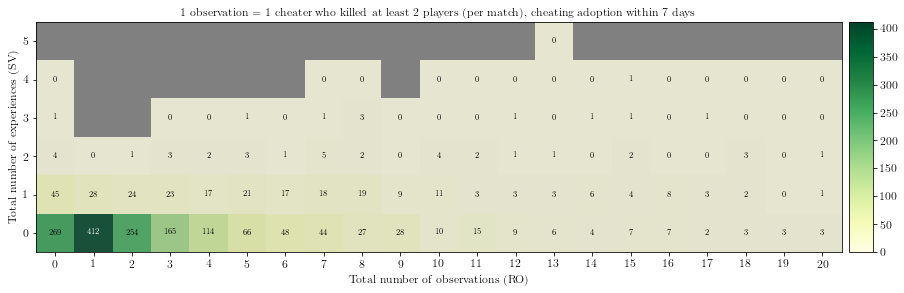

In [24]:
fig, ax = plt.subplots()
img1 = ax.imshow(freq_piv, cmap='YlGn', alpha=0.8)
ax.set_xticks(np.arange(freq_piv.shape[1]))
ax.set_yticks(np.arange(freq_piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SV)')

textcolors = ["k", "w"]

for y in range(freq_piv.shape[0]):
    for x in range(freq_piv.shape[1]):
        if np.isnan(freq_piv[x][y]) == False:
            text = ax.text(x, y, int(freq_piv[x][y]), ha="center", va="center",
                           color=textcolors[1 if freq_piv[x][y] >= 300 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/2_RO_SV_freq.png')

Plot a cumulative proportion heatmap.

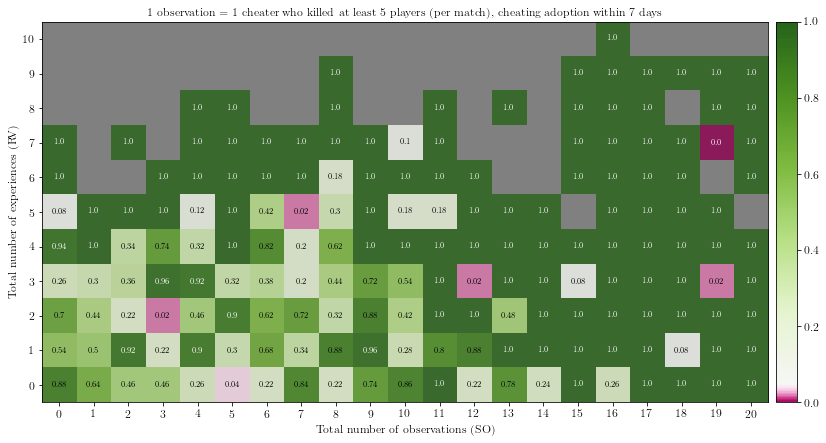

In [44]:
merged_df = pd.read_csv('data/RV_SO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
# merged_df = merged_df.drop(merged_df[merged_df.total_exp > 8].index)

test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
test_dat['count'] = (test_dat.iloc[:, 3:].values >= test_dat[['E']].values).sum(axis=1).astype(int)
test_dat['cum_prop'] = test_dat['count'] / 50

test_dat = test_dat.round({"cum_prop":2})
print(test_dat.head())

cum_prop = pd.pivot_table(test_dat, values="cum_prop",index=["total_exp"], columns=["total_obs"])
print(cum_prop)

norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(cum_prop, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(cum_prop.shape[1]))
ax.set_yticks(np.arange(cum_prop.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (RV)')

textcolors = ["k", "w"]

for y in range(cum_prop.shape[0]):
    for x in range(cum_prop.shape[1]):
        if np.isnan(cum_prop[x][y]) == False:
            text = ax.text(x, y, cum_prop[x][y], ha="center", va="center",
                           color=textcolors[1 if cum_prop[x][y] <= 0.01 or cum_prop[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/3_SO_RV_cum_prop.png')

In [48]:
merged_df = pd.read_csv('data/SV_RO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
# merged_df = merged_df.drop(merged_df[merged_df.total_exp > 8].index)

test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
test_dat['count'] = (test_dat.iloc[:, 3:].values >= test_dat[['E']].values).sum(axis=1).astype(int)
test_dat['cum_prop'] = test_dat['count'] / 50

test_dat = test_dat.round({"cum_prop":2})
print(test_dat.head())

   total_obs  sev_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0          0        0  269.0  259.0  269.0  246.0  281.0  254.0  260.0  258.0   
1          1        0  412.0  440.0  427.0  449.0  427.0  433.0  444.0  436.0   
2          2        0  254.0  247.0  244.0  239.0  243.0  255.0  236.0  240.0   
3          3        0  165.0  156.0  167.0  164.0  169.0  155.0  160.0  143.0   
4          4        0  114.0  105.0  115.0  113.0  104.0  122.0  104.0  115.0   

   ...    R43    R44    R45    R46    R47    R48    R49    R50  count  \
0  ...  265.0  268.0  259.0  256.0  258.0  276.0  268.0  262.0      9   
1  ...  441.0  435.0  415.0  420.0  429.0  420.0  426.0  432.0     49   
2  ...  251.0  234.0  261.0  258.0  253.0  254.0  251.0  236.0     12   
3  ...  167.0  166.0  164.0  177.0  156.0  158.0  168.0  175.0     18   
4  ...  101.0  104.0  110.0  104.0  106.0  108.0  105.0  107.0     16   

   cum_prop  
0      0.18  
1      0.98  
2      0.24  
3      0.36  
4   

In [49]:
cum_prop = pd.pivot_table(test_dat, values="cum_prop",index=["sev_exp"], columns=["total_obs"])
print(cum_prop)

total_obs    0     1     2     3     4     5     6     7     8     9   ...  \
sev_exp                                                                ...   
0          0.18  0.98  0.24  0.36  0.32  0.88  0.90  0.48  0.82  0.40  ...   
1          0.62  0.14  0.42  0.46  0.82  0.18  0.28  0.30  0.14  0.84  ...   
2          0.82  1.00  0.40  0.10  0.46  0.30  0.82  0.02  0.92  1.00  ...   
3          0.50   NaN   NaN  1.00  1.00  0.08  1.00  0.18  0.00  1.00  ...   
4          1.00   NaN   NaN   NaN   NaN   NaN   NaN  1.00  1.00   NaN  ...   
5           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

total_obs   11    12    13    14    15    16    17    18    19    20  
sev_exp                                                               
0          0.1  0.74  0.68  0.94  0.44  0.56  0.86  0.50  0.38  0.48  
1          0.9  0.84  0.58  0.48  0.38  0.04  0.62  0.60  1.00  0.88  
2          0.5  0.72  0.76  1.00  0.52  1.00  1.00  0.04  1.00  0.56  
3          1.0  0.40

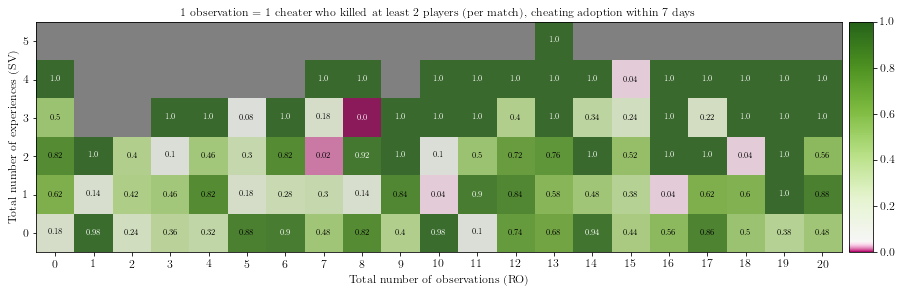

In [50]:
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(cum_prop, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(cum_prop.shape[1]))
ax.set_yticks(np.arange(cum_prop.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SV)')

textcolors = ["k", "w"]

for y in range(cum_prop.shape[0]):
    for x in range(cum_prop.shape[1]):
        if np.isnan(cum_prop[x][y]) == False:
            text = ax.text(x, y, cum_prop[x][y], ha="center", va="center",
                           color=textcolors[1 if cum_prop[x][y] <= 0.01 or cum_prop[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/2_RO_SV_cum_prop.png')

Plot a cumulative frequency heatmap.

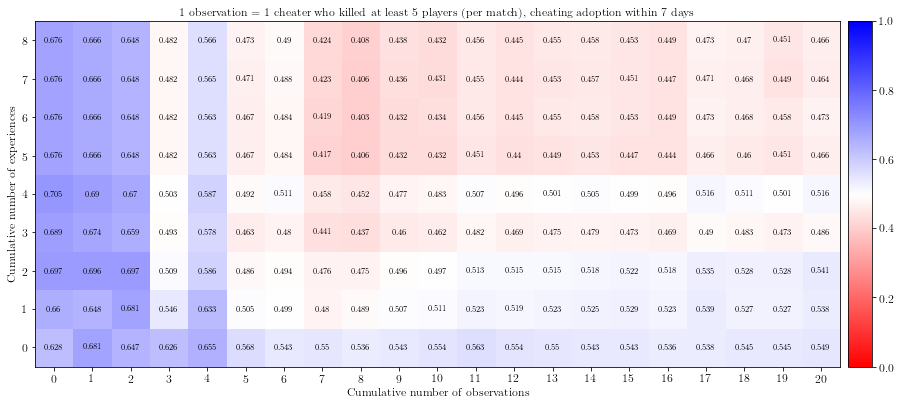

In [43]:
arr = np.array(freq)
emp_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)

freq = pd.pivot_table(test_dat, values="R1",index=["total_exp"], columns=["total_obs"], fill_value=0)
print(freq)

arr = np.array(freq)
ran_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)
print(ran_cumsum)

for i in range(2, 6):
    freq = pd.pivot_table(test_dat, values="R" + str(i),index=["total_exp"], columns=["total_obs"], fill_value=0)
    arr = np.array(freq)
    temp_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)
    ran_cumsum += temp_cumsum
    
print(ran_cumsum)

rand_mean = ran_cumsum / 5
cdf_mat = scipy.stats.poisson.cdf(emp_cumsum, rand_mean)
pmf_mat = scipy.stats.poisson.pmf(emp_cumsum, rand_mean)
prob_mat = 1 - cdf_mat + pmf_mat

prob_mat = prob_mat.round(3)
print(prob_mat)

cum_piv = pd.DataFrame(data=prob_mat).rename_axis(index='total_exp', columns='total_obs')
print(cum_piv)

fig, ax = plt.subplots()
norm = DivergingNorm(vmin=0, vcenter=0.5, vmax=1)
img1 = ax.imshow(cum_piv, norm=norm)
ax.set_xticks(np.arange(cum_piv.shape[1]))
ax.set_yticks(np.arange(cum_piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Cumulative number of observations')
plt.ylabel('Cumulative number of experiences')

textcolors = ["k", "w"]

for y in range(cum_piv.shape[0]):
    for x in range(cum_piv.shape[1]):
        if np.isnan(cum_piv[x][y]) == False:
            text = ax.text(x, y, cum_piv[x][y], ha="center", va="center",
                           color=textcolors[1 if cum_piv[x][y] <= 0.1 or cum_piv[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/cum_cnt_p_vals.png')